In [1]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.9 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-rrxw948i
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-rrxw948i
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=b9cf997e13a92e8495a1f167711310fbf03312914f51416af6eb68bb694020c3
  Stored in directory: /tmp/pip-ephem-wheel-cache-xlgpmvba/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


# Load CLIP model

In [60]:
import numpy as np
import torch
from pkg_resources import packaging
import pandas as pd

print("Torch version:", torch.__version__)

Torch version: 2.1.0+cu118


In [3]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [4]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 65.5MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [5]:
# 드라이브에 연결

from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


# Zero shot Image Classification

In [83]:
csv_file_path = '//content/drive/MyDrive/Study/ML_TeamProject/labeled.csv'

data = pd.read_csv(csv_file_path)
common = data['Common']
scientific = data['Scientific']

text_data = list(zip(common, scientific))
texts = []

for i in range(len(text_data)):
  txt = f'a photo of {text_data[i][0]}, {text_data[i][1]}'
  texts.append(txt)

print(text_data)
len(text_data)
print(texts)

[('almond_mushroom', 'agaricus_subrufescens'), ('amanita_gemmata', 'amanita_gemmata'), ('amethyst_chanterelle', 'cantharellus_amethysteus'), ('amethyst_deceiver', 'laccaria_amethystina'), ('aniseed_funnel', 'clitocybe_odora'), ('ascot_hat', 'boletus/hortiboletus_bubalinus'), ('bay_bolete', 'boletus/imleria_badia'), ('bearded_milkcap', 'lactarius_pubescens'), ('beechwood_sickener', 'russula_nobilis'), ('beefsteak_fungus', 'fistulina_hepatica'), ('birch_polypore', 'fomitopsis_betulina'), ('birch_woodwart', 'jackrogersella_multiformis'), ('bitter_beech_bolete', 'boletus/caloboletus_calopus'), ('bitter_bolete', 'boletus/tylopilus_felleus'), ('black_bulgar', 'bulgaria_inquinans'), ('black_morel', 'morchella_importuna'), ('blackening_brittlegill', 'russula_nigricans'), ('blackening_polypore', 'Meripilus_giganteus'), ('blackening_waxcap', 'hygrocybe_conica'), ('blue_roundhead', 'stropharia_caerulea'), ('blushing_bracket', 'daedaleopsis_confragosa'), ('blushing_rosette', 'abortiporus_biennis')

1
torch.Size([215, 77])


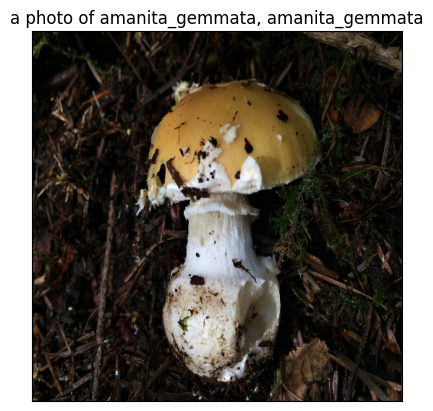

In [100]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

data_root = '/content/drive/MyDrive/Study/ML_TeamProject/mushroom_data_new'

mushroom_dataset = ImageFolder(data_root)
dataloader = DataLoader(mushroom_dataset, batch_size=32, shuffle=True)

# Prepare the inputs
image, class_id = mushroom_dataset[55]
print(class_id)
# plt.subplot(2, 4, 2)
plt.imshow(image)
plt.title(f"{texts[class_id]}")
plt.xticks([])
plt.yticks([])

image_input = preprocess(image).unsqueeze(0).to(device)
text_inputs = torch.cat([clip.tokenize(texts)]).to(device)
# text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in mushroom_dataset.classes]).to(device)

print(text_inputs.shape)

In [101]:
# Calculate features
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(10)

In [102]:
# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{mushroom_dataset.classes[index]:>16s}: {100 * value.item():.2f}%")


Top predictions:

  false_deathcap: 20.12%
white_false_death_cap: 11.46%
        deathcap: 7.40%
      panthercap: 6.95%
 amanita_gemmata: 6.33%
  warted_amanita: 5.25%
grey_spotted_amanita: 2.48%
  tawny_grisette: 2.06%
     the_blusher: 1.87%
white_dapperling: 1.65%
